In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae.jla import *
import simulators.jla_supernovae.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###
# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Simulation args for ABC
simABC_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args]

# Compressed dataset
data = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [4]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [5]:
# Create the DELFI MDN object
n_components = 3
names = ['\Omega_m', 'w_0', 'M_\mathrm{B}', '\alpha', '\beta', '\delta M']
labels =  ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 64s 1ms/step - loss: 12.9471 - val_loss: 9.9915
Epoch 2/50
45000/45000 [==============================] - 61s 1ms/step - loss: 9.2077 - val_loss: 8.6223
Epoch 3/50
45000/45000 [==============================] - 84s 2ms/step - loss: 8.2354 - val_loss: 7.9429
Epoch 4/50
45000/45000 [==============================] - 73s 2ms/step - loss: 7.7640 - val_loss: 7.6025
Epoch 5/50
45000/45000 [==============================] - 68s 2ms/step - loss: 7.4358 - val_loss: 7.2653
Epoch 6/50
45000/45000 [==============================] - 68s 2ms/step - loss: 7.1925 - val_loss: 7.1370
Epoch 7/50
45000/45000 [==============================] - 65s 1ms/step - loss: 7.0254 - val_loss: 7.0086
Epoch 8/50
45000/45000 [==============================] - 63s 1ms/step - loss: 6.9289 - val_loss: 6.8763
Epoch 9/50
45000/45000 [==============================] - 65s 1ms/step - 

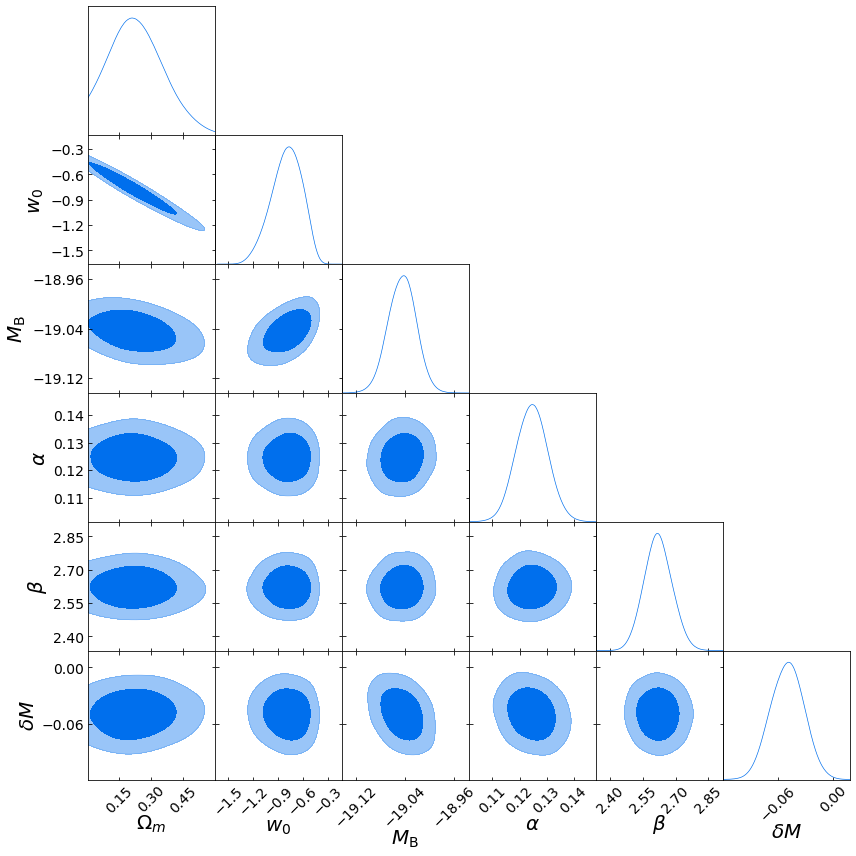

In [6]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 1s 2ms/step - loss: 9.0817 - val_loss: 7.9136
Epoch 2/100
450/450 [==============================] - 1s 2ms/step - loss: 7.7530 - val_loss: 7.4979
Epoch 3/100
450/450 [==============================] - 1s 2ms/step - loss: 7.4085 - val_loss: 7.4786
Epoch 4/100
450/450 [==============================] - 1s 2ms/step - loss: 7.1873 - val_loss: 7.4567
Epoch 5/100
450/450 [==============================] - 1s 2ms/step - loss: 7.0479 - val_loss: 7.4279
Epoch 6/100
450/450 [==============================] - 1s 2ms/step - loss: 6.8577 - val_loss: 7.3960
Epoch 7/100
450/450 [==============================] - 1s 2ms/step - loss: 6.8474 - val_loss: 7.3666
Epoch 8/100
450/450 [==============================] - 1s 2ms/step - loss: 6.7745 - val_loss: 7.2325
Epoch 9/100
450/450 [==============================] - 1s 2ms/step - loss: 6.7086 - val_loss: 7.2789
Epoch 10/100

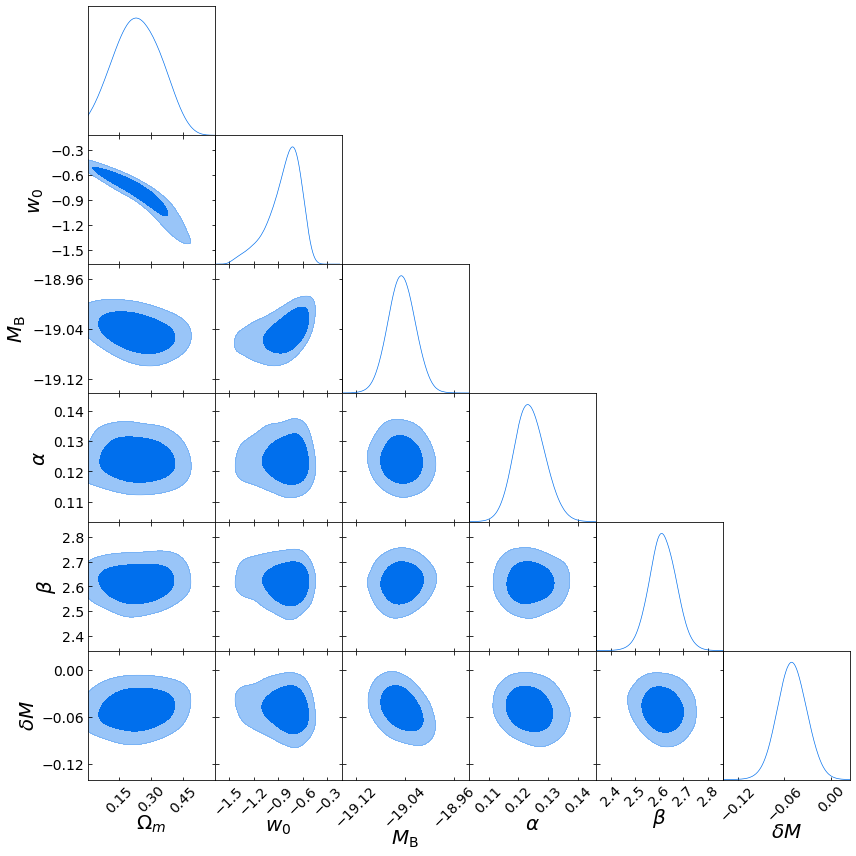

Population 1/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 6.2765 - val_loss: 6.5019
Epoch 2/100
900/900 [==============================] - 1s 2ms/step - loss: 6.1560 - val_loss: 6.4555
Epoch 3/100
900/900 [==============================] - 1s 2ms/step - loss: 6.1397 - val_loss: 6.4634
Epoch 4/100
900/900 [==============================] - 1s 2ms/step - loss: 6.1210 - val_loss: 6.4052
Epoch 5/100
900/900 [==============================] - 2s 2ms/step - loss: 6.1052 - val_loss: 6.3999
Epoch 6/100
900/900 [==============================] - 2s 2ms/step - loss: 6.0970 - val_loss: 6.4719
Epoch 7/100
900/900 [==============================] - 2s 2ms/step - loss: 6.0658 - val_loss: 6.3861
Epoch 8/100
900/900 [==============================] - 2s 2ms/step - loss: 6.0454 - val_loss: 6.4096
Epoch 9/100
900/900 [==============================] - 2s 2ms/step - l

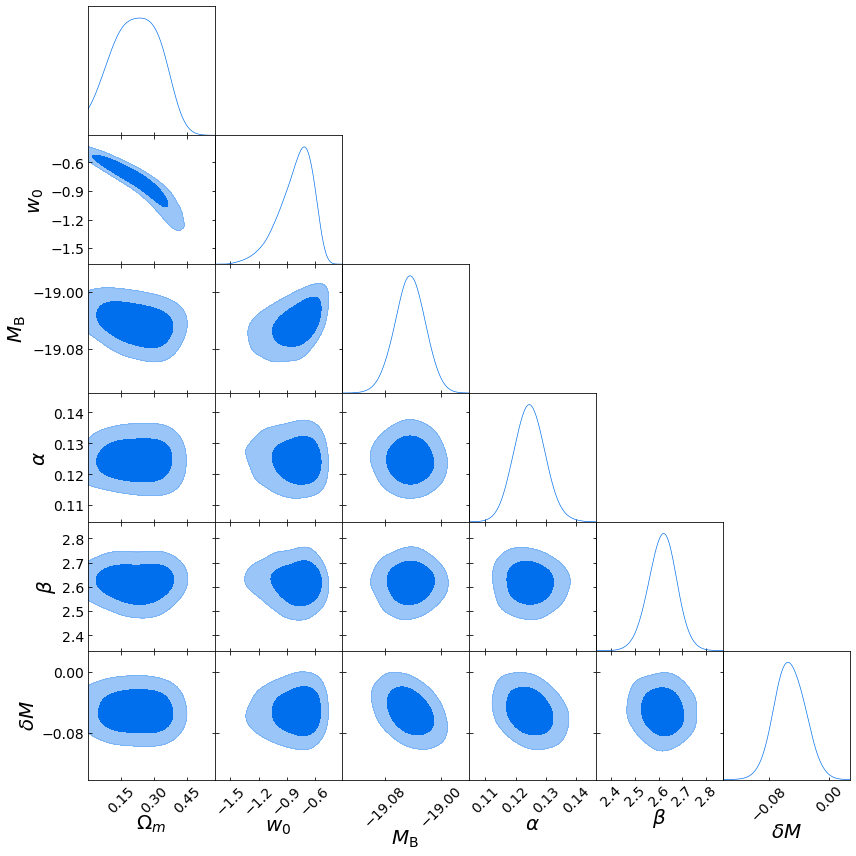

Population 2/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 2s 2ms/step - loss: 6.1280 - val_loss: 6.6841
Epoch 2/100
1350/1350 [==============================] - 2s 2ms/step - loss: 6.0956 - val_loss: 6.6608
Epoch 3/100
1350/1350 [==============================] - 2s 1ms/step - loss: 6.0909 - val_loss: 6.6611
Epoch 4/100
1350/1350 [==============================] - 2s 1ms/step - loss: 6.0716 - val_loss: 6.6784
Epoch 5/100
1350/1350 [==============================] - 2s 1ms/step - loss: 6.0681 - val_loss: 6.6792
Epoch 6/100
1350/1350 [==============================] - 2s 1ms/step - loss: 6.0675 - val_loss: 6.6694
Epoch 7/100
1350/1350 [==============================] - 2s 2ms/step - loss: 6.0764 - val_loss: 6.6553
Epoch 8/100
1350/1350 [==============================] - 3s 2ms/step - loss: 6.0653 - val_loss: 6.7046
Epoch 9/100
1350/1350 [==============================

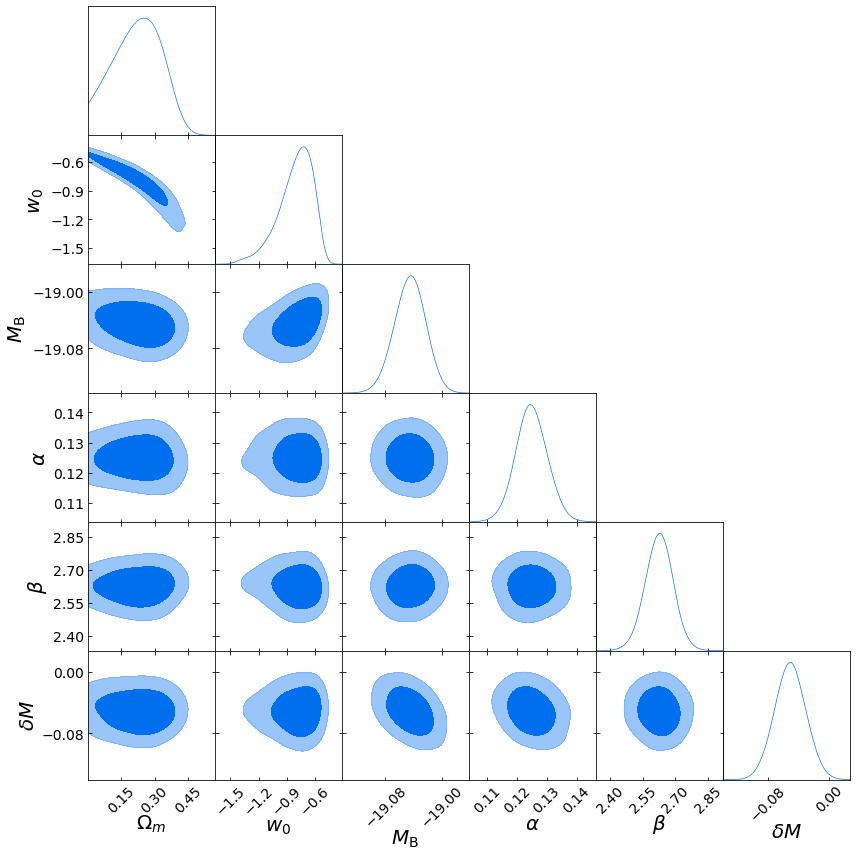

Population 3/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1546 - val_loss: 6.5279
Epoch 2/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1384 - val_loss: 6.5162
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 6.1348 - val_loss: 6.5151
Epoch 4/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1267 - val_loss: 6.5038
Epoch 5/100
1800/1800 [==============================] - 3s 2ms/step - loss: 6.1326 - val_loss: 6.5129
Epoch 6/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1470 - val_loss: 6.5370
Epoch 7/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1209 - val_loss: 6.5940
Epoch 8/100
1800/1800 [==============================] - 3s 1ms/step - loss: 6.1264 - val_loss: 6.5251
Epoch 9/100
1800/1800 [==============================

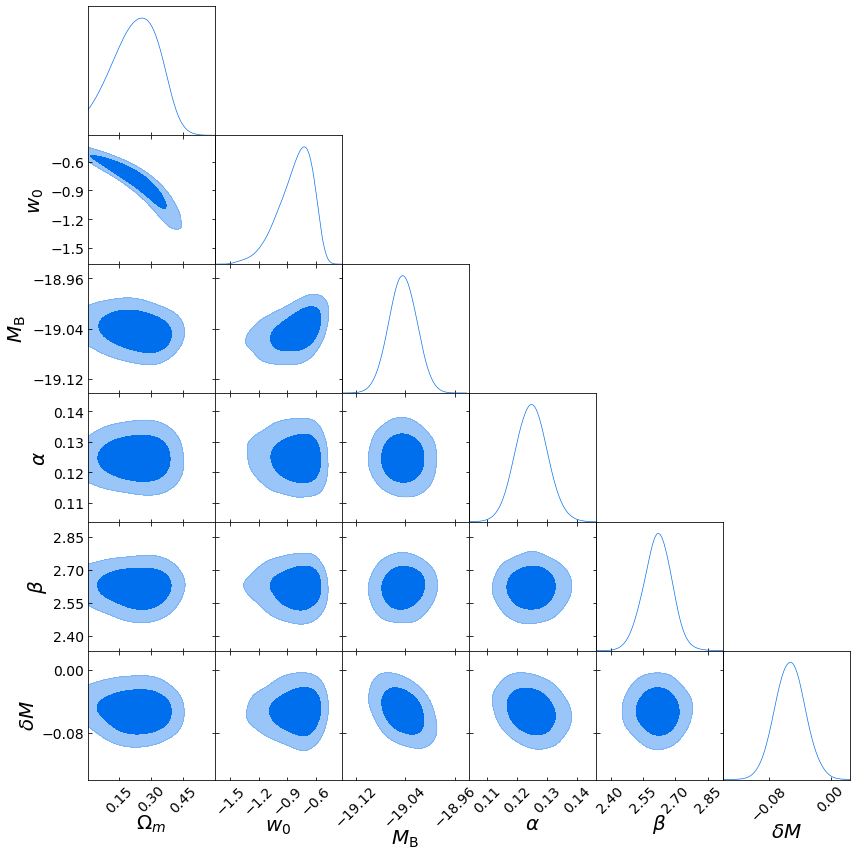

Population 4/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 7s 3ms/step - loss: 6.1563 - val_loss: 6.6966
Epoch 2/100
2250/2250 [==============================] - 7s 3ms/step - loss: 6.1508 - val_loss: 6.6362
Epoch 3/100
2250/2250 [==============================] - 7s 3ms/step - loss: 6.1541 - val_loss: 6.6670
Epoch 4/100
2250/2250 [==============================] - 8s 4ms/step - loss: 6.1449 - val_loss: 6.6115
Epoch 5/100
2250/2250 [==============================] - 5s 2ms/step - loss: 6.1373 - val_loss: 6.6688
Epoch 6/100
2250/2250 [==============================] - 3s 2ms/step - loss: 6.1469 - val_loss: 6.6311
Epoch 7/100
2250/2250 [==============================] - 3s 1ms/step - loss: 6.1381 - val_loss: 6.6549
Epoch 8/100
2250/2250 [==============================] - 3s 1ms/step - loss: 6.1458 - val_loss: 6.6306
Epoch 9/100
2250/2250 [==============================

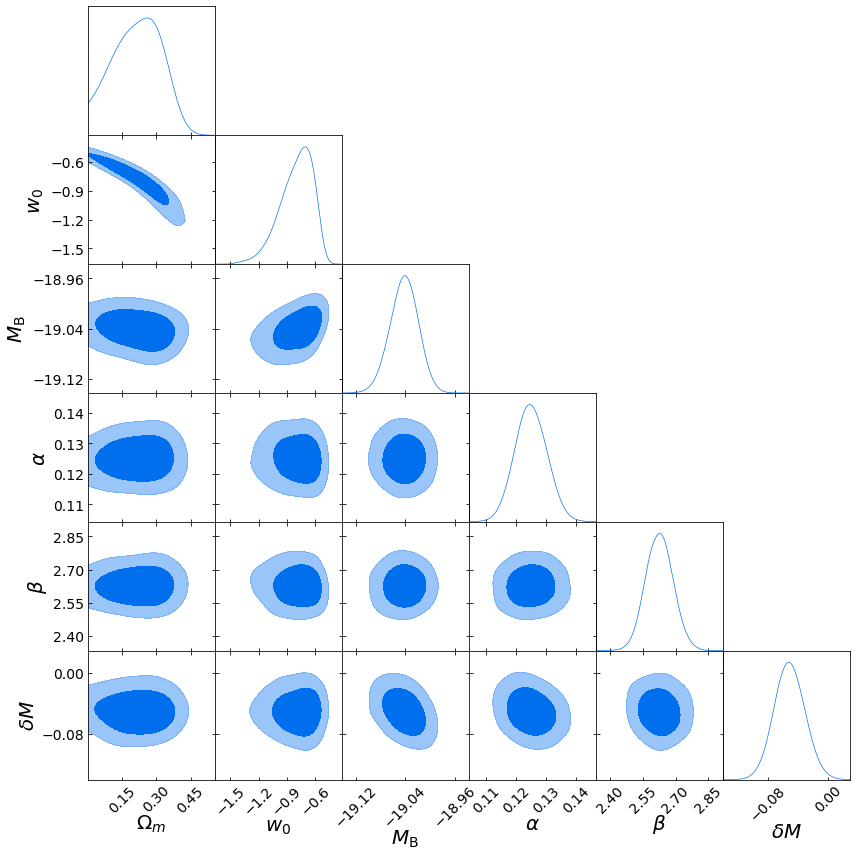

Population 5/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1796 - val_loss: 6.4250
Epoch 2/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1846 - val_loss: 6.4106
Epoch 3/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1835 - val_loss: 6.4094
Epoch 4/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1753 - val_loss: 6.3882
Epoch 5/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1783 - val_loss: 6.3850
Epoch 6/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1764 - val_loss: 6.3686
Epoch 7/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1645 - val_loss: 6.4138
Epoch 8/100
2700/2700 [==============================] - 4s 1ms/step - loss: 6.1653 - val_loss: 6.3749
Epoch 9/100
2700/2700 [==============================

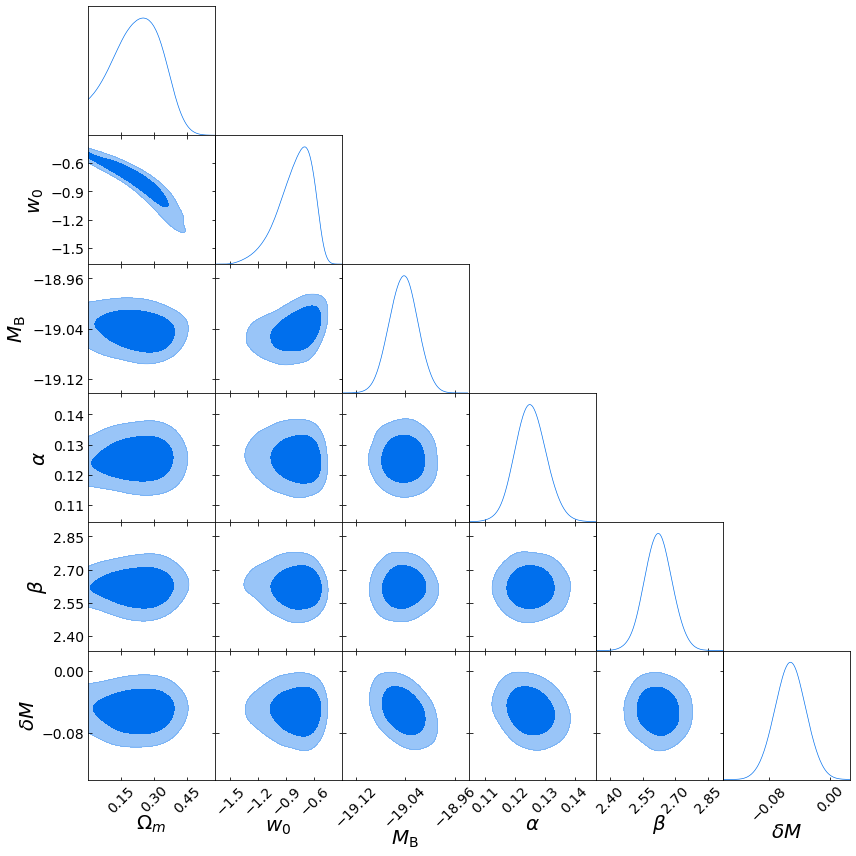

Population 6/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1810 - val_loss: 6.2264
Epoch 2/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1766 - val_loss: 6.2271
Epoch 3/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1873 - val_loss: 6.2140
Epoch 4/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1839 - val_loss: 6.2130
Epoch 5/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1776 - val_loss: 6.2365
Epoch 6/100
3150/3150 [==============================] - 8s 2ms/step - loss: 6.1720 - val_loss: 6.2272
Epoch 7/100
3150/3150 [==============================] - 8s 3ms/step - loss: 6.1731 - val_loss: 6.2192
Epoch 8/100
3150/3150 [==============================] - 8s 3ms/step - loss: 6.1721 - val_loss: 6.2287
Epoch 9/100
3150/3150 [==============================

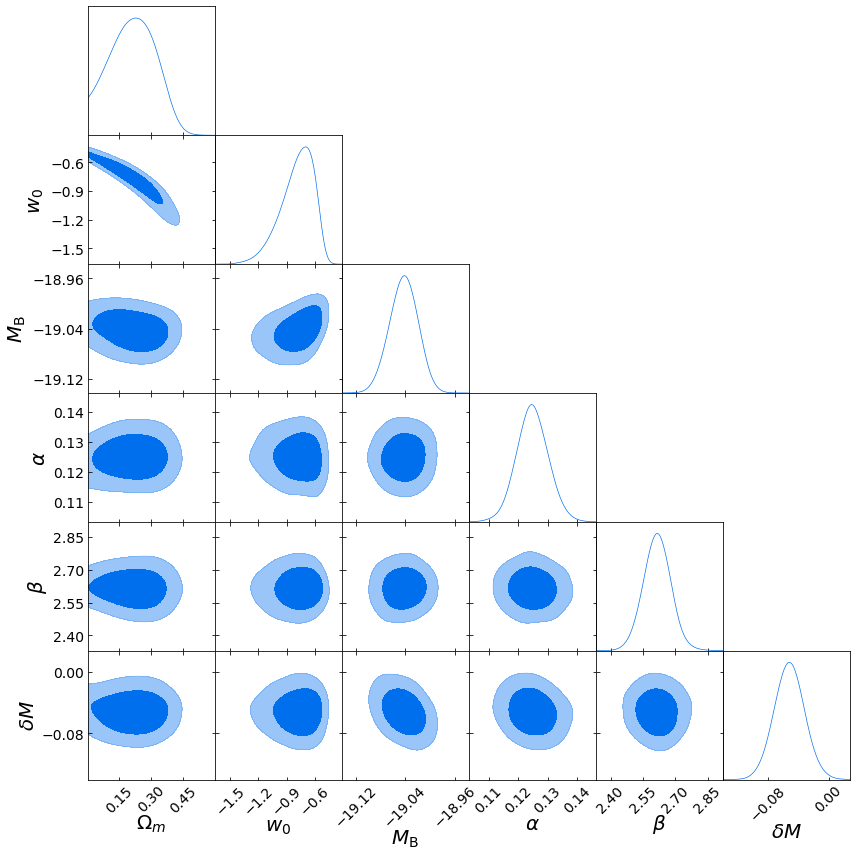

Population 7/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 9s 3ms/step - loss: 6.1757 - val_loss: 6.5285
Epoch 2/100
3600/3600 [==============================] - 9s 2ms/step - loss: 6.1719 - val_loss: 6.5228
Epoch 3/100
3600/3600 [==============================] - 5s 2ms/step - loss: 6.1708 - val_loss: 6.5377
Epoch 4/100
3600/3600 [==============================] - 5s 1ms/step - loss: 6.1730 - val_loss: 6.5268
Epoch 5/100
3600/3600 [==============================] - 5s 1ms/step - loss: 6.1716 - val_loss: 6.5236
Epoch 6/100
3600/3600 [==============================] - 5s 1ms/step - loss: 6.1660 - val_loss: 6.5314
Epoch 7/100
3600/3600 [==============================] - 5s 1ms/step - loss: 6.1699 - val_loss: 6.5285
Epoch 8/100
3600/3600 [==============================] - 5s 1ms/step - loss: 6.1691 - val_loss: 6.5676
Epoch 9/100
3600/3600 [==============================

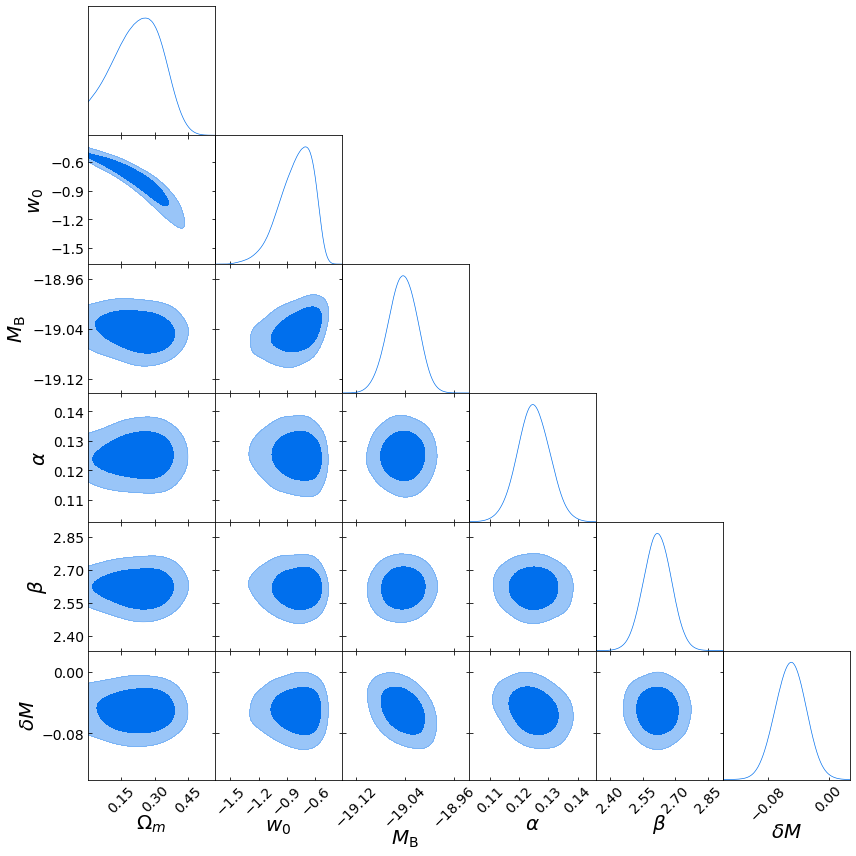

Population 8/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 6s 2ms/step - loss: 6.1974 - val_loss: 6.5130
Epoch 2/100
4050/4050 [==============================] - 6s 2ms/step - loss: 6.2028 - val_loss: 6.5119
Epoch 3/100
4050/4050 [==============================] - 6s 2ms/step - loss: 6.2060 - val_loss: 6.5085
Epoch 4/100
4050/4050 [==============================] - 6s 2ms/step - loss: 6.2079 - val_loss: 6.5196
Epoch 5/100
4050/4050 [==============================] - 6s 2ms/step - loss: 6.1987 - val_loss: 6.5235
Epoch 6/100
4050/4050 [==============================] - 7s 2ms/step - loss: 6.1970 - val_loss: 6.5318
Epoch 7/100
4050/4050 [==============================] - 10s 2ms/step - loss: 6.1935 - val_loss: 6.5192
Epoch 8/100
4050/4050 [==============================] - 10s 2ms/step - loss: 6.1999 - val_loss: 6.5261
Epoch 9/100
4050/4050 [============================

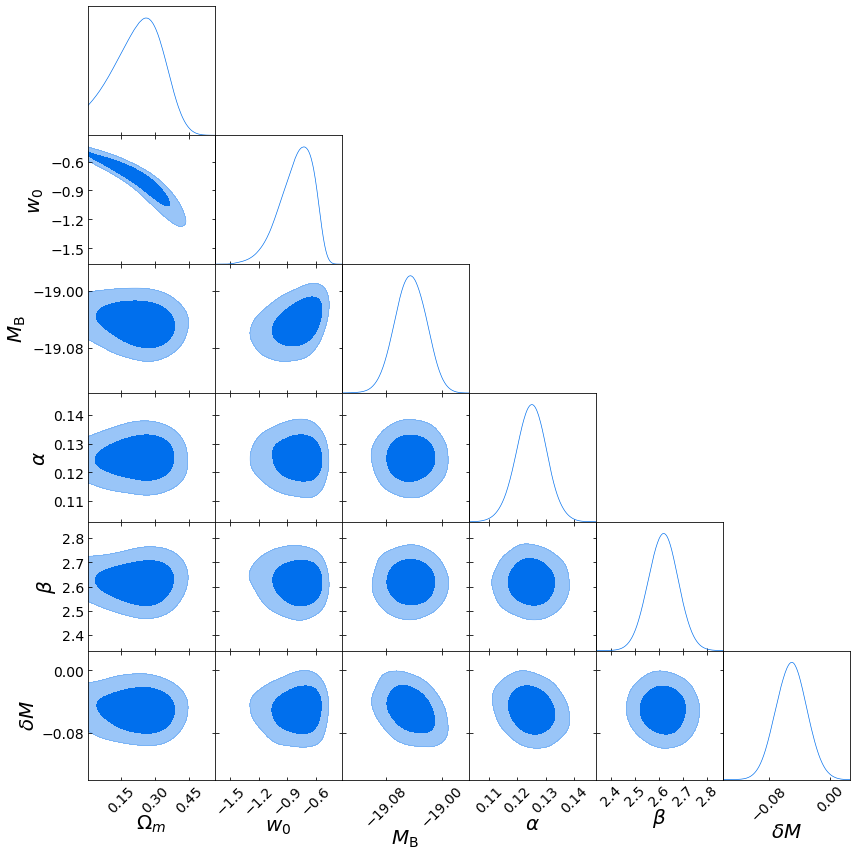

Population 9/9
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2242 - val_loss: 6.4819
Epoch 2/100
4500/4500 [==============================] - 8s 2ms/step - loss: 6.2106 - val_loss: 6.4564
Epoch 3/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2095 - val_loss: 6.4551
Epoch 4/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2069 - val_loss: 6.4598
Epoch 5/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2134 - val_loss: 6.4730
Epoch 6/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2237 - val_loss: 6.4605
Epoch 7/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2221 - val_loss: 6.4789
Epoch 8/100
4500/4500 [==============================] - 7s 2ms/step - loss: 6.2231 - val_loss: 6.4559
Epoch 9/100
4500/4500 [==============================

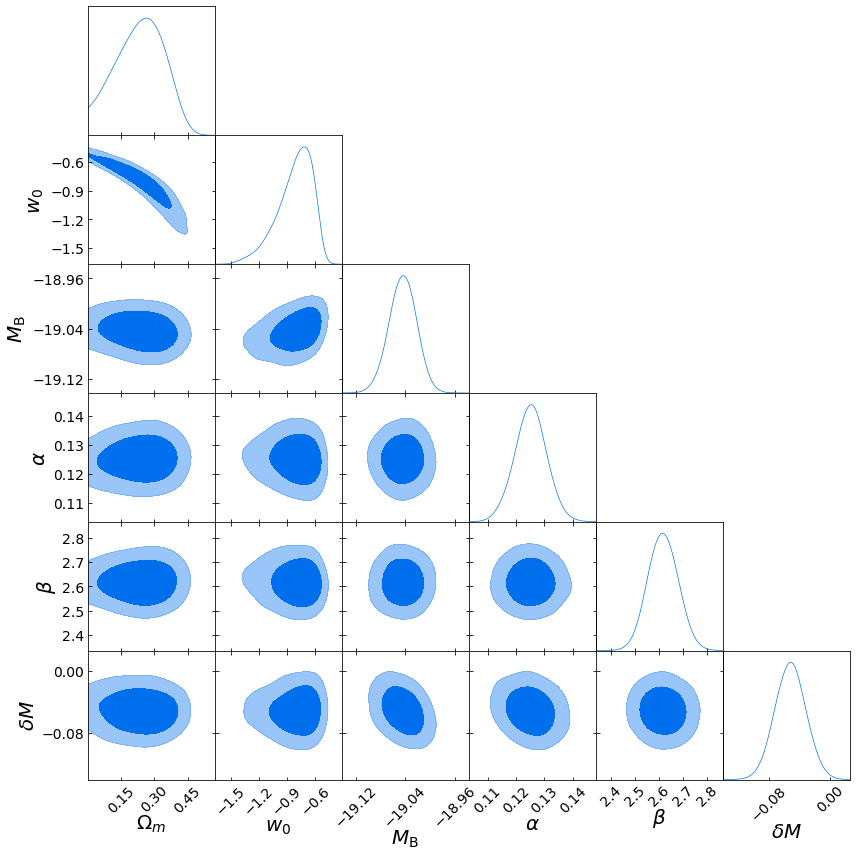

Final round of training with larger SGD batch size...
Train on 4500 samples, validate on 500 samples
Epoch 1/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.2205 - val_loss: 6.4917
Epoch 2/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.2294 - val_loss: 6.4632
Epoch 3/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.2053 - val_loss: 6.4527
Epoch 4/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.1970 - val_loss: 6.4676
Epoch 5/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.2112 - val_loss: 6.4681
Epoch 6/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.2087 - val_loss: 6.4557
Epoch 7/300
4500/4500 [==============================] - 15s 3ms/step - loss: 6.1905 - val_loss: 6.4636
Epoch 8/300
4500/4500 [==============================] - 13s 3ms/step - loss: 6.1897 - val_loss: 6.4820
Epoch 9/300
4500/4500 [==============================] - 15s 3ms/st

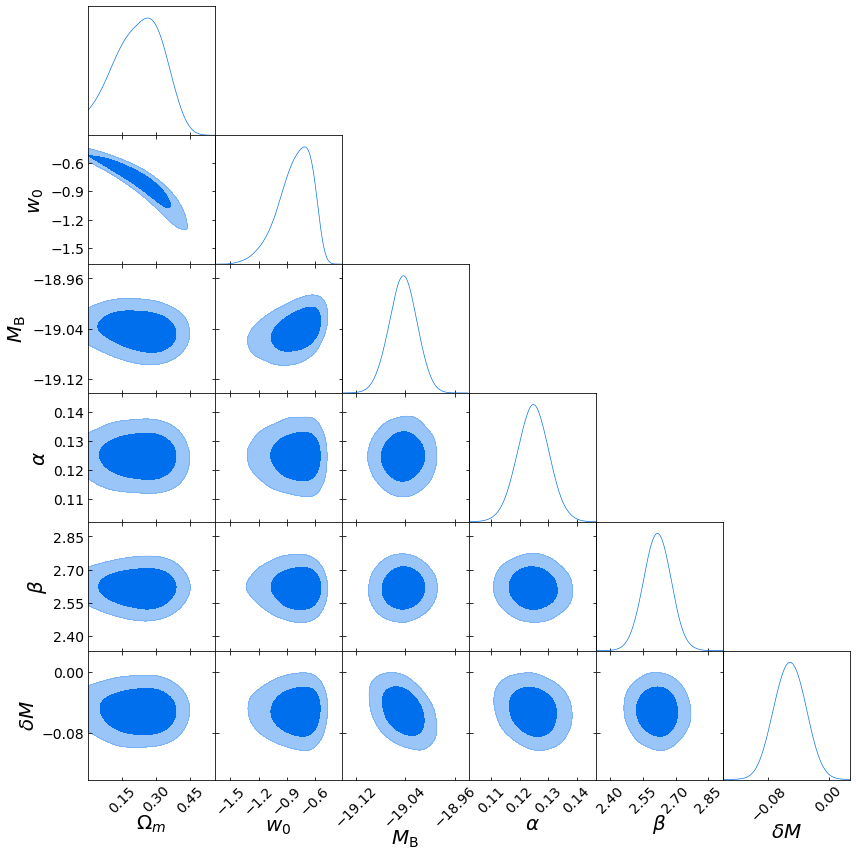

In [7]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

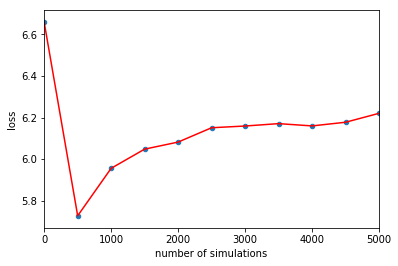

In [9]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()